# Homework 3: Reproducibility in Climate Studies

* **Statistics 159/259, Spring 2022**
* **Due 03/23/2023, 23:59PM PT**
* Prof. F. Pérez and GSI F. Sapienza, Department of Statistics, UC Berkeley.
* This assignment is worth a maximum of **50 points**.
* Assignment type: **group homework assignment** (Check on Ed Discussion about group's assignments).

## 2. The West Coast Heat Wave

In 2016 [Dr. Chelle Gentemann](https://cgentemann.github.io) and collaborators published a [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL071039) on the heat wave in the ocean off the California coast

The analysis was then performed using Matlab to process scientific data. To make Figure 1, here are the following steps:
- Download 4 TB of data from NASA PO.DAAC data archive via FTP
- Go through each day of data and subset to the West Coast Region to reduce size and save each subsetted day
- Go through 2002-2012 and create a daily climatology and save all 365 days of the climatology
- Go through each day of data and calculate the anomaly and save each day's anomaly

This whole process took about 1-2 month. 
Below we will do this using MUR SST data on AWS Open Data Program in a few minutes using Python.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

Subset all the data to just the West Coast region

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

This is how a rough version of one of the plots in the paper look like

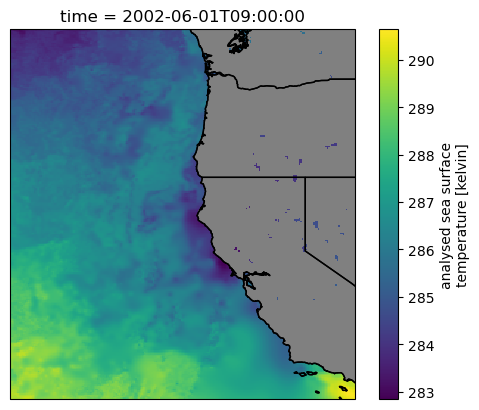

In [3]:
ds.analysed_sst[0, :, :].plot()

# Plot on a map
ax = plt.subplot(projection=crs)
ds.analysed_sst[0, :, :].plot(ax=ax, transform=crs)
ax.coastlines("10m", color="k")
ax.add_feature(cfeature.LAND, color="grey")
ax.add_feature(cfeature.STATES.with_scale("10m"))

### Question 4 [10 points]

Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

In [4]:
import numpy as np
import matplotlib.colors as mcolors

subset_ds = ds.sel(time=slice('2002-01-01','2012-12-31'))
target_ds =  ds.sel(time=slice('2014-01-01', '2016-12-31'))
anomalies = target_ds.groupby('time.dayofyear') - subset_ds.groupby('time.dayofyear').mean(dim='time')
#Set colorbar
colors = ['#0000FF','#0629d6','#0aabf0','#FFFFFF','#FFFFFF', '#fffb00','#e39309','#b80606'] 
positions = [0,0.15, 0.25, 0.45,0.55, 0.75, 0.85, 1] 
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))

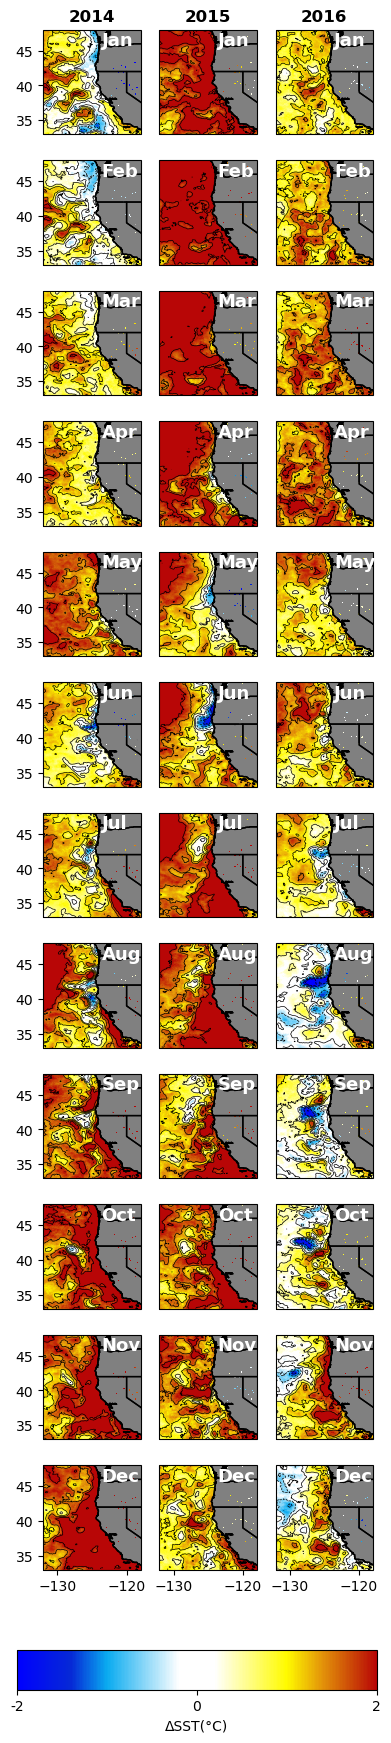

In [5]:
# Create the subplots
fig, axes = plt.subplots(nrows=12, 
                         ncols=3, 
                         figsize=(9, 20), 
                         sharex=True, 
                         sharey=True, 
                         subplot_kw={'projection': ccrs.PlateCarree()})

ims = []
for year in range(2014, 2017):
    for month in range(1, 13):
        time_str = f'{year}-{month:02d}'
        month_name = pd.to_datetime(time_str, format="%Y-%m").month_name()[:3]
        month_data = anomalies.sel(time=time_str).mean(dim='time')['analysed_sst']
        row, col = month - 1, year - 2014
        im = month_data.plot(ax=axes[row, col], 
                             transform=ccrs.PlateCarree(), 
                             cmap = custom_cmap, 
                             norm = mcolors.Normalize(vmin=-2, vmax=2), 
                             add_colorbar=False)
        ims.append(im)

        # Extract longitude, latitude, and data values
        lons, lats = np.meshgrid(anomalies['lon'], anomalies['lat'])
        month_data_values = month_data.values

        # Add contour lines
        contour_levels = np.arange(-2, 2.5, 0.5)  
        axes[row, col].contour(lons, lats, 
                               month_data_values, 
                               levels=contour_levels, 
                               colors='k', 
                               linewidths=0.5, 
                               transform=ccrs.PlateCarree())

        axes[row, col].add_feature(cfeature.LAND, color="grey")
        axes[row, col].add_feature(cfeature.STATES.with_scale("10m"))
        axes[row, col].coastlines("10m", color="k")

        # Add month names in white color
        axes[row, col].text(0.6, 0.85, 
                            month_name, 
                            fontsize=13, 
                            color="white", 
                            fontweight="semibold", 
                            transform=axes[row, col].transAxes)
        axes[row, col].set(xlabel=None, ylabel=None)

        # Add the years
        if row == 0:
            axes[row, col].set_title(f"{year}", 
                                     color="black", 
                                     fontweight="bold")
        # Add tick labels
        if row == 11:
            axes[row, col].set_xticks([-130, -120])
        if col == 0:
            axes[row, col].set_yticks([35, 40, 45])


fig.subplots_adjust(hspace=0.25, wspace=-0.75)

# Define the position and size of the colorbar axes
cax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
cbar = plt.colorbar(ims[-1], cax=cax, orientation='horizontal')
cbar.set_label('ΔSST(°C)', loc='center')
cbar.set_ticks([-2, 0, 2])
cbar.set_ticklabels([-2, 0, 2])

plt.show()